In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Wavefunction generation
from scf_runs import run_lda_he, run_casci
scf_checkfile, opt_checkfile, mf_lda = run_lda_he()
ci_checkfile, mc, opt_chkfile, vmc_chkfile = run_casci(scf_checkfile, nroots=4, ncas = 4)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py
He atom neutral LDA spin=0
HF
converged SCF energy = -2.86151422722833  <S^2> = 2.4424907e-15  2S+1 = 1
LDA
converged SCF energy = -2.83456474290722  <S^2> = 3.1086245e-15  2S+1 = 1
CASCI nelecas up/down (1, 1)

WARN: Mulitple states found in CASCI solver. First state is used to compute the Fock matrix and natural orbitals in active space.

CASCI state   0  E = -2.87136683894789  E(CI) = -2.87136683894789  S^2 = 0.0000000
CASCI state   1  E = -1.96435654140743  E(CI) = -1.96435654140743  S^2 = 2.0000000
CASCI state   2  E = -1.82265262782591  E(CI) = -1.82265262782591  S^2 = 0.0000000
CASCI state   3  E = -1.55439202079245  E(CI) = -1.55439202079245  S^2 = 2.0000000
Available output from CASCI: <KeysViewHDF5 ['ci', 'fci', 'mc_mo_energy', 'mf_mo_energy', 'mo_coeff', 'mo_occ', 'ncas', 'ncore', 'nelecas']>


In [140]:
# Multi determinant boson new gradient
import importlib, bosonrecipes, bosonslater, bosonwftools
modules = [importlib, bosonrecipes, bosonslater, bosonwftools]
for m in modules:
    importlib.reload(m)

import importlib, slater, pyscftools,recipes, wftools, mc
modules = [importlib, slater, pyscftools,recipes, wftools, mc]
for m in modules:
    importlib.reload(m)


# import pyqmc.pyscftools as pyscftools

nconfig = 323
multi = True
if multi:
    mol, mf, mcc = pyscftools.recover_pyscf(scf_checkfile, ci_checkfile = ci_checkfile)
    target_root = 0
    if not hasattr(mcc.ci, "shape") or len(mcc.ci.shape) == 3:
        mcc.ci = mcc.ci[target_root]
else:
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    mcc = None
    
wfb, to_opt = bosonwftools.generate_boson_wf(
        mol, mf, mc=mcc, jastrow=None, jastrow_kws=None, slater_kws=None
        )

wfs, to_opt = wftools.generate_wf(
        mol, mf, mc=mcc, jastrow=None, jastrow_kws=None, slater_kws=None
        )


In [141]:
nconfig = 100
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
signb, phib = wfb.recompute(configs)
signs, phis = wfs.recompute(configs)

[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


In [142]:
s, v = wfb.value_dets()
v.shape

(16, 100)

In [143]:
wfb._det_map[0]

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

In [144]:
updets = wfs._dets[0][:, :, wfs._det_map[0]]
dndets = wfs._dets[1][:, :, wfs._det_map[1]]

In [183]:
import gpu 
# Value efficient
upref = gpu.cp.amax(updets[1]).real
dnref = gpu.cp.amax(dndets[1]).real
ndet = len(wfs._det_map[0])
logvals = 2*(updets[1] - upref + dndets[1] - dnref)
wf_val = 1./ndet * gpu.cp.einsum("id->i", gpu.cp.exp(logvals))

wf_sign = np.nan_to_num(wf_val / gpu.cp.abs(wf_val))
wf_logval = 1./2 * np.nan_to_num(gpu.cp.log(gpu.cp.abs(wf_val)) + 2*(upref + dnref))
wf_logval - wfb.value()[1]

[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
wf

In [218]:
# Ovlp from slaters
nconf, nelec, _ = configs.configs.shape

for wfi in wfb.wfs:
    wfi.recompute(configs)

phib_sign, phib_logval = wfb.value() # Eq. 4
phib_val = phib_sign * np.nan_to_num(np.exp(phib_logval)) #[c]

phase, log_vals = [
    np.nan_to_num(np.array(x)) for x in zip(*[wfi.value() for wfi in wfb.wfs])
]

psi = phase * np.nan_to_num(np.exp(log_vals))
ovlp_ij = np.einsum("lc,nc, c->cln", psi.conj(), psi, (1./phib_val**2))

AttributeError: 'BosonWF' object has no attribute 'wfs'

In [82]:
sign_list = []
logval_list = []
for i in range(ndet):
    updets = wfs._dets[0][:, :, wfs._det_map[0][i]]
    dndets = wfs._dets[1][:, :, wfs._det_map[1][i]]
    upref = gpu.cp.amax(updets[1]).real
    dnref = gpu.cp.amax(dndets[1]).real
    logvals = 2*(updets[1] - upref + dndets[1] - dnref)
    wf_val =  gpu.cp.exp(logvals)

    wf_sign = updets[0] * dndets[0]
    wf_logval = 1./2 * np.nan_to_num(gpu.cp.log(gpu.cp.abs(wf_val)) + 2*(upref + dnref))
    sign_list.append(wf_sign)
    logval_list.append(wf_logval)
phase2 = np.array(sign_list)
log_vals = np.array(logval_list)
psi2 = phase2 * np.nan_to_num(np.exp(log_vals))    
ovlp2_ij = np.einsum("lc,nc, c->cln", psi2.conj(), psi2, (1./phib_val**2))

In [44]:
np.max(phase - phase2)

0.0

In [45]:
np.max(ovlp_ij - ovlp2_ij)

2.1316282072803006e-14

In [184]:
# Gradient
e = 0
epos = configs.electron(e)
gradb, _, _ = wfb.gradient_value(e, epos)
gradb[0]

array([ 8.89879826e-01,  6.18379115e-01, -4.45214355e-01,  8.82466398e-02,
        7.83703487e-01,  2.57656555e-01,  6.74025873e-01, -1.76600445e-01,
        1.05419531e-01,  4.73043981e-01,  9.28387365e-01,  8.92807566e-01,
       -3.45848452e-01,  4.55904119e-01, -3.12014238e-01,  7.07730658e-01,
        4.80600743e-04, -6.61024320e-01, -7.99257673e-01,  3.01908144e-01,
       -4.58378065e-01, -2.76625317e-01,  6.12141372e-01,  6.39109562e-01,
        4.03125677e-01,  1.23226183e+00, -1.47495021e-01, -4.95984730e-01,
       -4.78597091e-01, -7.31103119e-01, -3.03041141e-01, -6.37691611e-01,
       -3.47071382e-01,  1.07680248e-01, -3.50691557e-01,  2.77957667e-01,
        8.80517376e-01, -6.57993493e-01, -9.19350522e-01,  8.24314204e-01,
        4.05612304e-01, -7.48990172e-02, -2.87115306e-01,  6.75491161e-02,
        5.90559311e-01,  5.82011814e-03,  1.13861646e+00,  5.21702709e-01,
        6.34157377e-01,  6.87224948e-01,  3.33191517e-01, -8.06470017e-02,
       -4.29605952e-01,  

In [185]:
s = int(e >= wfs._nelec[0])
aograd = wfs.orbitals.aos("GTOval_sph_deriv1", epos)
mograd = wfs.orbitals.mos(aograd, s)
mograd_vals = mograd[:, :, wfs._det_occup[s]]
jacobi = gpu.cp.einsum(
    "ei...dj,idj...->ei...d",
    mograd_vals,
    wfs._inverse[s][..., e - s * wfs._nelec[0]],
)
det_coeff = 1./ndet
upref = gpu.cp.amax(wfs._dets[0][1]).real
dnref = gpu.cp.amax(wfs._dets[1][1]).real

det_array = (
    wfs._dets[0][0, :, wfs._det_map[0]]
    * wfs._dets[1][0, :, wfs._det_map[1]]
    * gpu.cp.exp(
        wfs._dets[0][1, :, wfs._det_map[0]]
        + wfs._dets[1][1, :, wfs._det_map[1]]
        - upref
        - dnref
    )
)

numer = det_coeff * gpu.cp.einsum(
    "ei...d,di->ei...",
    jacobi[..., wfs._det_map[s]],
    det_array**2
)

denom = det_coeff * gpu.cp.einsum(
    "di->i...",
    det_array**2
)
g2 = numer[1:] / denom

In [186]:
i = 2
gradb[i]/g2[i]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [193]:
dv = wfb.value_dets()[1]
dv.shape

(16, 100)

In [194]:
dg = wfb.gradient_dets(e, epos)
dg.shape

(16, 3, 100)

In [200]:
v = wfb.value()[1]
v.shape

[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


(100,)

In [216]:
gc = np.einsum('di,dei->ei', np.exp(2*(dv-v)), dg)

In [217]:
i = 2
gc[i] - gradb[i]

array([ 5.55111512e-17,  8.32667268e-17, -3.33066907e-16,  4.44089210e-16,
       -7.77156117e-16, -5.55111512e-17, -8.88178420e-16,  1.38777878e-17,
       -2.77555756e-17,  3.33066907e-16, -3.88578059e-16, -4.44089210e-16,
        6.66133815e-16,  6.66133815e-16, -7.77156117e-16, -1.11022302e-15,
        0.00000000e+00,  8.88178420e-16, -3.33066907e-16,  2.22044605e-16,
       -1.11022302e-16, -5.55111512e-17, -4.16333634e-17, -1.80411242e-16,
       -4.44089210e-16, -3.33066907e-16, -1.11022302e-15,  7.77156117e-16,
        3.33066907e-16, -3.33066907e-16,  1.66533454e-16,  1.11022302e-16,
        8.32667268e-17, -6.66133815e-16,  1.11022302e-16, -5.55111512e-17,
        2.77555756e-16, -3.33066907e-16,  3.33066907e-16,  4.44089210e-16,
        1.11022302e-16,  3.88578059e-16,  1.11022302e-16,  3.33066907e-16,
       -3.33066907e-16, -4.44089210e-16,  1.38777878e-16,  2.22044605e-16,
       -8.32667268e-16,  0.00000000e+00,  1.11022302e-16,  4.44089210e-16,
       -2.22044605e-16, -

In [209]:
gc[i]

array([-0.43737053, -0.22962243,  0.66011218, -0.92181637, -0.6067954 ,
       -0.41737773, -0.55451653, -0.01586487,  0.23523568, -0.73660888,
        0.40051342, -1.30455022,  1.19696156, -0.60174582, -0.99327511,
       -0.61016005,  0.52395411,  1.52765922,  0.43738634, -0.75350801,
        0.40754371,  0.33378998, -0.10533445, -0.1031861 ,  1.09678994,
        0.60610625, -1.01052355,  0.86653441, -0.87555881,  0.67239813,
        0.41417647,  0.06646584,  0.14914367, -1.07393164,  0.57997485,
       -0.45320726,  0.49570146,  0.87113897,  0.75572263, -0.67211567,
       -0.14698759, -0.41227672,  0.42926996,  0.97392509, -0.79603571,
        0.61539168, -0.17477241, -0.68951613, -0.45467954, -0.72445164,
        0.55785151, -0.89120447,  0.70270382, -0.40689001, -0.60055509,
        0.25947207,  1.12432769,  0.23756668, -0.22685656, -0.10940892,
        0.58186485,  0.9460864 , -0.42906137, -0.43937658,  0.74744865,
        0.92446082, -0.78971944,  0.28586488,  0.23547337,  0.10

In [13]:
e=0
gradb, _, _ = wfb.gradient_value(e, configs.electron(e))
grads, _, _ = wfs.gradient_value(e, configs.electron(e))

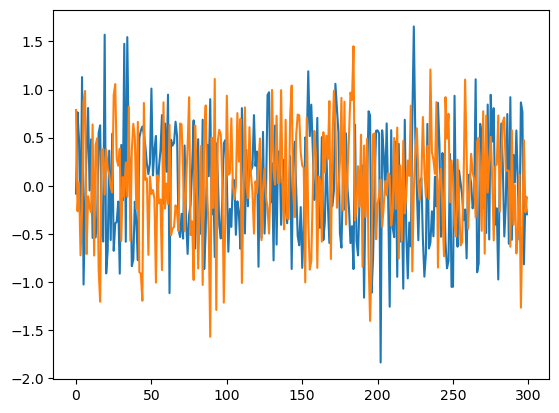

In [14]:
# Differnce in gradients
plt.plot(gradb.flatten())
plt.plot(gradb.flatten()-grads.flatten())

In [10]:
gradbr, _ = wfb.gradient_value_real(e, configs.electron(e))
gradbl, _, _ = wfb.gradient_value_log(e, configs.electron(e))

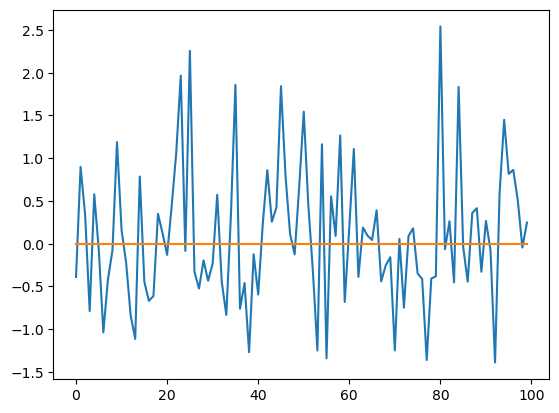

In [11]:
# check between the real and log gradients
idx = 0
plt.plot(gradbl[idx])
plt.plot(gradbl[idx]-gradbr[idx]/np.exp(phib))